In [0]:
%run ./helper_functions

In [0]:
from pyspark.ml.feature import PCA

In [0]:
### Functions to Perform Page Rank
## Writes results to {blob_url}/pagerank-month/*
def create_graph(df_grouped):
    origin_ids = df_grouped.select('ORIGIN_AIRPORT_ID').distinct().withColumnRenamed("ORIGIN_AIRPORT_ID", "id")
    destination_ids = df_grouped.select('DEST_AIRPORT_ID').distinct().withColumnRenamed("DEST_AIRPORT_ID", "id")
    vertices = origin_ids.union(destination_ids).distinct()
    
    edges = df_grouped.rdd.flatMap(lambda x: ((x[0], x[1]) for _ in range(x[3]))).toDF()\
        .withColumnRenamed("_1", "src").withColumnRenamed("_2", "dst")
    graph = GraphFrame(vertices, edges).cache()
    return graph
    
def format_data(data):
    data = data.select(*["YEAR", "MONTH", 'ORIGIN_AIRPORT_ID', "DEST_AIRPORT_ID", "DEP_DEL15"]).filter("DEP_DEL15 = 1")
    df_group = data.groupBy(*["ORIGIN_AIRPORT_ID", "DEST_AIRPORT_ID"])\
        .agg(
            sum("DEP_DEL15").alias("DEL_COUNT"),
            func.count(func.lit(1)).alias('NumFlights')
        )
    return df_group

def process_pagerank(df, pagerank):
    pr_sum = pagerank.vertices.agg(func.sum("pagerank").alias('pr_sum'))
    pr_sum = pr_sum.collect()[0].asDict()['pr_sum']
    result = pagerank.vertices\
    .withColumn("normal_pagerank", pagerank.vertices['pagerank']/pr_sum)\
    .drop("pagerank").withColumnRenamed("normal_pagerank", 'pagerank')\
    .withColumnRenamed("id", 'pagerank_id')
    
    join = df.join(result,
                    on= df['DEST_AIRPORT_ID'] == result['pagerank_id'],
                    how='left')
    return join

def pagerank(data, time_period, verbose=False):
    blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
    if time_period == "YEAR":
        time_col = "YEAR"
    elif time_period == "MONTH":
        time_col = "MONTH"
    else:
        raise Exception(f"time_period must be ('YEAR' or 'MONTH') not {time_period}")
    
    time_dict = {"YEAR": [2015, 2016, 2017, 2018, 2019], "MONTH": [i for i in range(1,13)]}
    
    # Origin ID and Dest ID must be the first two columns
    data = data.select(*['id', 'ORIGIN_AIRPORT_ID', "DEST_AIRPORT_ID", "DEP_DEL15", "YEAR", "MONTH"]).cache()
    full_time_start = time.time()
    for year in time_dict["YEAR"]:
        iter_start_time = time.time() 
        if time_period == "YEAR":            
            start = time.time()
            print("Filtering data...", end="") if verbose else None
            df = data.filter(f"YEAR = {year}")
            print(f"Finished in {time.time()-start}") if verbose else None
            
            start = time.time()
            print("Grouping Data...", end="") if verbose else None
            df_grouped = format_data(data)
            print(f"Finished in {time.time() -start}") if verbose else None
            
            start = time.time()
            print("Creating Graph...", end="") if verbose else None
            graph = create_graph(df_grouped)
            print(f"Finished in {time.time() - start}") if verbose else None
            
            start = time.time()
            print("Running Pagerank...", end="") if verbose else None
            pagerank = graph.pageRank(maxIter=5).cache()
            print(f"Finished in {time.time() - start}") if verbose else None
            
            start = time.time()
            print('Processing Pagerank Results...', end="") if verbose else None
            result = process_pagerank(df=df, pagerank=pagerank)
            print(f"Finished in {time.time() - start}") if verbose else None
            
            # Only write necessary columns  
            result_subset = result.select(*["id", "pagerank_id", "YEAR", "pagerank"])\
                                .withColumnRenamed("pagerank_id", "PR_DEST_AIRPORT_ID")
            start = time.time()
            print("Writing results...", end="") if verbose else None
            result_subset.write.mode("overwrite").parquet(f"{blob_url}/pagerank-year/{year}")
            print(f"Finished in {time.time() - start}") if verbose else None
            df.unpersist()
            df_grouped.unpersist()
            graph.unpersist()
            result.unpersist()
            result_subset.unpersist()
            print(f"Total iteration time: {time.time()-iter_start_time}") if verbose else None 
            print() if verbose else None
            
        elif time_period == "MONTH":
            for month in time_dict["MONTH"]:
                iter_start_time = time.time()
                print(f"Computing page rank for {year}-{month}") if verbose else None
                start = time.time()
                print("Filtering data...", end="") if verbose else None
                df = data.filter(f"YEAR = {year}").filter(f"MONTH = {month}")
                print(f"Finished in {time.time()-start}") if verbose else None

                start = time.time()
                print("Grouping Data...", end="") if verbose else None
                df_grouped = format_data(data)
                print(f"Finished in {time.time() -start}") if verbose else None

                start = time.time()
                print("Creating Graph...", end="") if verbose else None
                graph = create_graph(df_grouped)
                print(f"Finished in {time.time() - start}") if verbose else None

                start = time.time()
                print("Running Pagerank...", end="") if verbose else None
                pagerank = graph.pageRank(maxIter=5).cache()
                print(f"Finished in {time.time() - start}") if verbose else None
                
                start = time.time()
                print('Processing Pagerank Results...', end="") if verbose else None
                result = process_pagerank(df=df, pagerank=pagerank)
                print(f"Finished in {time.time() - start}") if verbose else None

                # Only write necessary columns  
                result_subset = result.select(*["id", "pagerank"])
                start = time.time()
                print("Writing results...", end="") if verbose else None
                result_subset.write.mode("overwrite").parquet(f"{blob_url}/pagerank-month/{year}-{month}")
                print(f"Finished in {time.time() - start}") if verbose else None
                
                # Clean up data
                df.unpersist()
                df_grouped.unpersist()
                graph.unpersist()
                result.unpersist()
                result_subset.unpersist()
                print(f"Total time for iteration: {time.time()-iter_start_time}") if verbose else None 
                print() if verbose else None
                
    print(f"Total run time: {time.time() - full_time_start}") if verbose else none

In [0]:
# Functions to join pagerank result to dataframe in feature-engineering folder
def join_pagerank(flight_weather, pagerank_folder):
    pagerank = spark.read.parquet(pagerank_folder).withColumnRenamed('id', 'pr_id')
    join = flight_weather.join(pagerank, 
                            on=(flight_weather["id"] == pagerank['pr_id']),
                            how = 'left')
    join = join.drop("pr_id")
    print(f"{join.count()=}")
    join.write.mode("overwrite").parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank")

In [0]:
# Assign Historic Pagerank results to each row to prevent data leakage
def compute_past_pagerank(flights_weather_pagerank):
    years = [2015, 2016, 2017, 2018, 2019]
    id_historical_pagerank_df = None
    i = 0
    for year in years:
        # We don't have data before 2015, so use previous month's page rank to compute
        # each month's page rank
        if year == 2015:
#             print("processing 2015")
            months = [i for i in range(1, 13)]
            for month in months:
                id_pr_df = None
                # We have no prior data for month one 
                if month == 1:
                    id_pr_df = flights_weather_pagerank.select(*['id', 'DEST_AIRPORT_ID', 'pagerank', "YEAR", "MONTH"])\
                                .filter(f"YEAR = {year} and MONTH = {month}")\
                                .withColumn('historical_pagerank', col('pagerank'))\
                                .select("id", "historical_pagerank")
                    
                else:    
                    past_df = flights_weather_pagerank.select(*['DEST_AIRPORT_ID', 'pagerank', "YEAR", "MONTH"])\
                    .filter(f"YEAR = 2015 and MONTH = {month-1}")\
                    .withColumnRenamed("pagerank", "historical_pagerank")\
                    .withColumnRenamed("DEST_AIRPORT_ID", "DEST_AIRPORT_ID_PAST")\
                    .withColumnRenamed("YEAR", "YEAR_PAST")\
                    .withColumnRenamed("MONTH", "MONTH_PAST")\
                    .groupBy(*["DEST_AIRPORT_ID_PAST", 'MONTH_PAST']).agg(first("historical_pagerank").alias('historical_pagerank'))
                    
                    current_df = flights_weather_pagerank.select(*['id', 'DEST_AIRPORT_ID', 'pagerank', "YEAR", "MONTH"])\
                    .filter(f"YEAR = {year} and MONTH = {month}")
                    
                    join_condition = [past_df['DEST_AIRPORT_ID_PAST'] == current_df['DEST_AIRPORT_ID']]
                    join = current_df.join(past_df, on=join_condition, how='left')        
                    
                    id_pr_df = join.select("id", "historical_pagerank")
                    
                    join.unpersist()
                    current_df.unpersist()
                    
                if id_historical_pagerank_df:
                    id_historical_pagerank_df = id_historical_pagerank_df.union(id_pr_df).cache()
                else:
                    id_historical_pagerank_df = id_pr_df
                print(f'Iteration {i} finished for {year}-{month}')
                i += 1
                id_pr_df.unpersist()
            
        # Compute historical page rank by using the value from the same month in the prior year       
        else:
            past_df = flights_weather_pagerank.select(*['DEST_AIRPORT_ID', 'YEAR', 'pagerank', "MONTH"])\
            .filter(f"YEAR = {year-1}")\
            .withColumnRenamed("pagerank", "historical_pagerank")\
            .withColumnRenamed("DEST_AIRPORT_ID", "DEST_AIRPORT_ID_PAST")\
            .withColumnRenamed("MONTH", "MONTH_PAST")\
            .groupBy(*["DEST_AIRPORT_ID_PAST", 'MONTH_PAST']).agg(first("historical_pagerank").alias('historical_pagerank'))
            
            current_df = flights_weather_pagerank.select(*['id', 'DEST_AIRPORT_ID', 'pagerank', "YEAR", "MONTH"])\
            .filter(f"YEAR = {year}")
            
            join_condition = [past_df['MONTH_PAST'] == current_df['MONTH'],
             past_df['DEST_AIRPORT_ID_PAST'] == current_df['DEST_AIRPORT_ID']]
            join = current_df.join(past_df, on=join_condition, how='left')
            
            id_pr_df = join.select("id", "historical_pagerank")
            
            if id_historical_pagerank_df:
                id_historical_pagerank_df = id_historical_pagerank_df.union(id_pr_df)
            else:
                id_historical_pagerank_df = id_pr_df
                
            past_df.unpersist()
            current_df.unpersist()
            join.unpersist()
            id_pr_df.unpersist()
                
            print(f"Iteration {i} finished for {year}")
#             print(f'{id_historical_pagerank_df.count()=} ')
            i +=1 

    # Join historical page rank to main data 
    id_historical_pagerank_df = id_historical_pagerank_df.withColumn(f"hist_pr_id", col('id')).drop('id').cache()
    
    flight_df = flights_weather_pagerank.alias('flights')
    pr_df = id_historical_pagerank_df.alias('pr')
    
    condition = [col('flights.id') == col('pr.hist_pr_id')]
    
    join = flight_df.join(pr_df, on=(flight_df['id'] == pr_df['hist_pr_id']), how="left")
    
    join.write.mode("overwrite").parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
    

In [0]:
def fill_pagerank_na(df):
    pd_df = df.select('historical_pagerank', "YEAR").groupBy("YEAR").agg(min('historical_pagerank').alias("min_pagerank")) \
    .filter('YEAR=2015').select('min_pagerank').toPandas()
    val = float(pd_df.loc[0])
    df = df.fillna(value = {"historical_pagerank": val})
    df.write.mode("overwrite").parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")

In [0]:
def compute_trailing_delays(flight_weather_pagerank_historical):
    date_cols = ["YEAR", "MONTH", "DAY_OF_MONTH"] # Date columns for grouping and left side of join
    join_date_cols_right = [i+"_R" for i in date_cols] # date columns for the right side of the join 
    group = flight_weather_pagerank_historical.groupBy(*date_cols)\
                .sum('DEP_DEL15')\
                .withColumnRenamed("sum(DEP_DEL15)", "DEL_PER_DAY")\
                .withColumnRenamed("YEAR", "YEAR_R")\
                .withColumnRenamed("MONTH", "MONTH_R")\
                .withColumnRenamed("DAY_OF_MONTH", "DAY_OF_MONTH_R")
    
    # Compute 
    window = Window.orderBy(["YEAR_R", "MONTH_R", "DAY_OF_MONTH_R"])
    group_with_lag =  group.withColumn('lag_del_by_day', lag("DEL_PER_DAY", 1).over(window)).drop("DEL_PER_DAY")
    
    join_condition = [group_with_lag.YEAR_R == df.YEAR,
                      group_with_lag.MONTH_R == df.MONTH,
                      group_with_lag.DAY_OF_MONTH_R == df.DAY_OF_MONTH]
    
    joined_df = flight_weather_pagerank_historical.join(group_with_lag,
                                                       on = join_condition,
                                                       how= 'left').drop(*join_date_cols_right)
    return joined_df
    

In [0]:
# Multiply each windows' delay count by pagerank to estimate inbound delays 
def estimate_inbound_delays(df):
    df = df.withColumn('estimated_inbound_delays', col("lag_del_by_day") * col("historical_pagerank"))
    return df

In [0]:
# Perform string indexing and one-hot encoding on categorical variables; 
def create_synthetic_rows_for_encoding(data, categorical_variables, train_year, verbose=False):
    """Certain categorical variables will not have all values present in the training data (e.g. 2015 will be in train but we will not have an encoding for 2019 test data).
    This function adds synthetic rows with values from the test/validation set to ensure the encoder captures all possible values.
    These rows contain nulls and will be dropped by the vector assembler. """

    # Extract the categorical variables and a set of the original columns
    df_categorical = data.select(*categorical_variables)
    all_column_set = set(data.columns)

    if verbose:
        pre_count = df_flights_weather.count()  

    # Create a dictionary of distinct values for each variable
    distinct_dict = {k: [] for k in categorical_variables}
    for col in categorical_variables:
        # Arbitrary large number that should capture entirety of distinct values
        distinct_list = df_categorical.select(col).distinct().take(10000)
        distinct_dict[col].extend([i.asDict()[col] for i in distinct_list])

    if verbose:
        expected_new_cols = 0
        for k,v in distinct_dict.items():
            expected_new_cols += len(v)

    # Create a schema that matches the input dataset
    schema_dict = {}
    for field in data.schema.fields:
        schema_dict.update({field.name: field.dataType})

    # Generate rows with distinct values
    rows = []
    for k, v in distinct_dict.items():
        key = k
        distinct_values = v
        key_set = set([key])
        null_cols = all_column_set.difference(key_set)
        # Set null_columns to None
        schema_dict.update({k: None for k in schema_dict.keys()})
        for val in distinct_values:
            schema_dict.update({key: val})
            rows.append(Row(**schema_dict)) 

    # Convert rows to dataframe with original data schema and return the union 
    rdd = sc.parallelize(rows).map(lambda x: tuple(x))
    data = data.filter(f"YEAR <= {train_year}")
    distinct_df = rdd.toDF(schema = data.schema)
    union_data = data.union(distinct_df)
    if verbose:
        post_count = union_data.count()
        print(f"precount: {pre_count}, postcount: {post_count}, expected: {expected_new_cols}, diff: {post_count-pre_count}")
    return union_data

In [0]:
def validate_feature_set(df, all_cols):
    df_col_set = set(df.columns)
    all_col_set = set(all_cols)
    set_diff = df_col_set.difference(all_col_set)
    if set_diff:
        raise Exception(f"Some columns are unspecified. {set_diff=}")

In [0]:
def create_scaled_features(data, train_year, transform_years: list, keep_cols: list, categorical_variables: list, numeric_variables: list,
                           drop_variables: list, write=False):
    """
    Given the dataframe, apply one-hot-encoding to categorical variables, imput by mean for numeric variables, and apply standard scaler

    The combination of categorical and numeric variables generates the feature set.

    input: 
    data - df_flights_weather type dataframe
    train_year - the year the pipeline should be fit on inclusive of all prior years
    transform_years - the years the fitted model should be applied to
    keep_col - Columns to keep (dependent variables and year for cross-validation)
    categorical_variables - variables to be one-hot-encoded
    numeric_variables - numeric_variables
    """
    all_cols = keep_cols + categorical_variables + numeric_variables + drop_variables
    validate_feature_set(data, all_cols)
    
    # get distinct values for future data; also drops rows after train year
    train_data = create_synthetic_rows_for_encoding(data=data,
                                                    categorical_variables=categorical_variables,
                                                    train_year=train_year)

    # Index and encode categorical variables
    string_indexers = map(lambda c: StringIndexer(inputCol=c, outputCol=c+"_idx", handleInvalid = 'keep', stringOrderType="alphabetAsc"),
                        categorical_variables)
    ohe_encoders = map(lambda c: OneHotEncoder(inputCol=c + "_idx", outputCol=c+"_class"), categorical_variables)

    # Impute numeric variables by mean
    imputers = Imputer(inputCols = numeric_variables, outputCols = numeric_variables)

    # Assemble and scale all features
    features = [c+"_class" for c in categorical_variables] + numeric_variables
    assembler = VectorAssembler(inputCols=features, outputCol="features", handleInvalid="skip")
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)

    # Define pipeline
    pipeline_stages = list(string_indexers) + list(ohe_encoders) + [imputers, assembler, scaler, pca]
    pipeline = Pipeline(stages=pipeline_stages)

    # Filter data to <= training year
    model = pipeline.fit(train_data)

    # ToDo: Just apply the transformation on the full dataset
    # ToDo: Drop all non scaledFeatures except ID, YEAR, DEP_DELAY_NEW, DEP_DEL15
    transformed_data = model.transform(data)
    keep_cols.append('scaledFeatures')
    transformed_data = transformed_data.select(*keep_cols)
    cnt= transformed_data.count()
    print(f"Transformed data count is {cnt}")
    if write:
        file_name = f"transformed-data-trained-on-{train_year}"
        transformed_data.write.mode("overwrite").parquet(f"{blob_url}/feature-engineering/{file_name}")
        transformed_data.unpersist()
        return transformed_data
    else:
        return transformed_data

In [0]:
def feature_engineering_pipeline(blob_url, compute_pagerank=False):
    flight_weather_df = read_joined_flights_weather(env='prod')
    
    ## Portion 1: Each of these steps writes data associated with pagerank 
    # Step 1: Run pagerank (writes to 'blob_url/pagerank-month/*')
    if compute_pagerank:
        print("Computing pagerank")
        pagerank(data=flights_weather_df, time_period="MONTH")
    
    # Step 2: Join pagerank to flights_weather_df (writes to 'blob_url/feature-engineering/flight_weather_pagerank')
    print("Joining pagerank results")
    pagerank_folder = f"{blob_url}/pagerank-month/*"
    join_pagerank(flight_weather_df, pagerank_folder)
    
    # Step 3: Compute historical pagerank to avoid data leakage (writes to 'blob_url/feature-engineering/flight-weather-pagerank-historical')
    print("Computing Historical pagerank results")
    df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank")
    compute_past_pagerank(flights_weather_pagerank=df)
    
    # Step 4: fill pagerank NA
    print("Filling Null pagerank values")
    df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
    fill_pagerank_na(df)
    df.unpersist()
    
    ## Portion 2: These steps will not write data until the end 
    df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
    # Step 5:
    print("Computing trailing delays")
    df = compute_trailing_delays(flight_weather_pagerank_historical=df)
        
    # Step 6: a
    print("Estimating inbound delays")
    df = estimate_inbound_delays(df)
    
    # Step 7: 
    # Define variable types; each type of variable is handled differently 
    categorical_variables = ['YEAR', 'QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', "DEP_HOUR_OF_UTC", 'OP_CARRIER_AIRLINE_ID', "DEST_AIRPORT_ID",
                             "ORIGIN_AIRPORT_ID",'DEST_STATE_FIPS', "DISTANCE_GROUP", "TIMEZONE"]
    numeric_variables = ["WND_ANGLE", "WND_SPEED", "CIG_DIM", "VIS_DIST", "TMP_AIR", "DEW_POINT", "SLP_DAY", "lon", "lat", 'neighbor_lon', 
                     'neighbor_lat', "DISTANCE", "DIV_AIRPORT_LANDINGS", "distance_to_neighbor", "lag_del_by_day", "historical_pagerank"]
    drop_cols = ["ORIGIN_WAC", "DEST_WAC", "FLIGHTS", "OP_CARRIER_FL_NUM", "MONTH_OBS", "YEAR_OBS", "FLIGHT_HOUR_OBS", "DEP_TIME", "DEP_HOUR_OF",
                "DEST_AIRPORT_SEQ_ID", "ORIGIN_AIRPORT_SEQ_ID", "pagerank", "hist_pr_id", "pr_id"]
    keep_cols = ["id", "DEP_DEL15", "DEP_DELAY_NEW"]
    transform_years = [2016, 2017, 2018, 2019]
    
    print("Creating encoded, imputed, and scaled features")
    create_scaled_features(data=df, train_year=2015,
                           transform_years=transform_years,
                           keep_cols=keep_cols,
                           categorical_variables=categorical_variables,
                           numeric_variables=numeric_variables,
                           drop_variables=drop_variables,
                           write=True)
    

In [0]:
# pca_data = spark.read.parquet(f"{blob_url}/feature-engineering/pca-data").cache()
# display(pca_data)

DEP_DEL15 DEP_DELAY_NEW YEAR pcaFeatures 0.0 0.0 2015 Map(vectorType -> dense, length -> 100, values -> List(-3.5798790498051613E-4, 7.24031715929113E-5, -0.0011807328848019497, 0.001579637945028456, -6.018467694423985E-4, 0.0020613024811360226, 8.150983100362041E-4, -8.904426807520568E-4, -0.0014011669415435986, 5.000086031680588E-4, 0.001525584757956873, -7.063039094196292E-4, -0.0014431248513887053, -0.0015766479614074541, -3.865559697883601E-5, -0.003922913577357683, 0.002105420050731233, -0.005329346070259053, 7.130540588864988E-4, -0.002095216293094537, 4.2153272703021724E-4, 7.982915052802779E-4, 0.0016491976831816961, 0.006990603837275519, 0.02457507685076691, 0.022804035263327794, -6.984787428306976E-4, 0.002369406083295536, 0.0010436105528050968, 3.177175276544022E-4, -1.6378204813557803E-4, 0.0015051420385703666, 7.770352677061317E-5, 8.690817730528466E-4, 8.749111350826372E-4, -0.001971568326554925, 0.001405033990980561, 6.196639663531186E-5, -0.004271762653291494, 0.0017085872103677787, 2.3156183096884682E-4, -0.002391647581377979, 0.0011914037360171402, 0.002383849895760044, -2.358956059723787E-6, 8.11444180976577E-4, -0.0030150649103389067, 0.00276947311435839, 0.002547528273714735, 0.003235393068253348, -5.748446801671565E-4, -0.004238254811246646, -1.651379409215954E-4, -0.004046122153502596, 0.001361877873886589, 0.0016580059432027827, 0.0012131116534280023, -0.002851804873142157, -7.749845468602042E-5, -5.083708670492312E-4, 3.6500032472693163E-4, -0.005862355642019501, 3.65117622569438E-5, 6.38429744998137E-4, -0.002238350971140213, 3.074951517709805E-4, 0.0014689712811105115, 7.830131722009085E-4, -2.6854480215946424E-4, -5.369838091527533E-4, -0.0014530000635779115, 0.003237076177168459, -0.0029073513482171932, -6.822688800320504E-4, 2.1536805299156374E-5, -2.3260516629976024E-4, -3.6138903225856793E-4, 0.0029798649053952245, 0.001804612913288988, 0.00262380793781131, -0.0028845541744951424, -0.001359164815352428, -0.002754476745639043, 0.0037713774328041955, 0.0032338633404239295, 0.0026093017941956004, -0.005317258705972752, 0.0010607017421644539, -0.04816845534846832, -0.003199383516484719, -1.483509228744681, -0.11630261214418085, 0.5731506353505582, 1.7374253021668324, 0.06282330292225005, 2.506336399416977, 1.0476389842318248, -0.499229500373998, -0.6845390518524682, 0.725709003815206)) 0.0 0.0 2015 Map(vectorType -> dense, length -> 100, values -> List(-3.0171979443596324E-4, 1.0350976360568075E-4, -0.0020173696351166895, -4.635258042524223E-4, -0.0027133457632559, 0.0024732530721251387, 1.5612033839795003E-4, 0.00862963755569801, -0.03227265810774962, 0.016893585298498576, 0.0150102578857166, -0.010913754056566227, -0.01786880530732166, -0.014369005875947973, 5.48376051939879E-4, -0.01806061856375144, 0.001423255750459768, -0.002286113400687721, -0.0026802804394162223, 0.008052820741180553, -0.009366175892383468, 2.806922573686398E-4, -0.0055306177032883215, 0.004871325110571909, -6.242449440510972E-4, -0.005369451801525754, 0.008199305222715458, 0.0030154112802942895, 0.020091047875927782, -0.015254142250086427, -4.8493614210469617E-4, -5.358219570739548E-4, -2.729431941955402E-4, 0.004127743133784082, 0.01707608782671776, -0.012348848801782011, -0.0016296784866221942, -1.4971105310271956E-4, -0.0032620663566593705, -0.0029169585094269276, -2.0509311890797399E-4, -0.007370624950496202, -0.0018370942607953144, -0.0043793149948008325, 0.021844461371765836, 0.014316213481963547, -3.2072447817502257E-4, 9.771414519862515E-4, 0.0018946587174119385, 0.0019594219809075026, -0.0010879414181910378, -0.0010805315198414646, 8.544842625201384E-4, -0.0012863550656885298, 0.0040947602439945704, 0.0025028556239095044, -0.004444732019542465, 0.010905953959376914, 0.0064439307310217705, -2.7218892242079E-4, -8.51764880433425E-5, -0.004961149859159556, 0.035453151220072344, 0.001411440829885383, 7.329406211238997E-4, 0.002294999932841935, -2.6208538677365435E-4, -0.0014186714228899232, 4.579274844160353E-4, 0.0019

In [0]:
# dbutils.fs().ls(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
# df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
# df = compute_trailing_delays(df)
# df = estimate_inbound_delays(df)
# display(df)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK OP_CARRIER_AIRLINE_ID OP_CARRIER_FL_NUM ORIGIN_AIRPORT_ID ORIGIN_AIRPORT_SEQ_ID ORIGIN_WAC DEST_AIRPORT_ID DEST_AIRPORT_SEQ_ID DEST_STATE_FIPS DEST_WAC DEP_TIME DEP_DEL15 DEP_DELAY_NEW FLIGHTS DISTANCE DISTANCE_GROUP DIV_AIRPORT_LANDINGS DEP_HOUR_OF DEP_HOUR_OF_UTC lat lon neighbor_lat neighbor_lon distance_to_neighbor YEAR MONTH_OBS FLIGHT_HOUR_OBS WND_ANGLE WND_SPEED CIG_DIM VIS_DIST TMP_AIR DEW_POINT SLP_DAY YEAR_OBS id pagerank historical_pagerank hist_pr_id lag_del_by_day estimated_inbound_delays 4 10 22 4 19977 1281 13830 1383002 2 12892 1289203 6 91 2033 0.0 0.0 1.0 2486.0 10 0 20 6 null null null null null 2015 null null null null null null null null null null 879 0.015200636118049268 0.03673256959913682 879 1470.0 53.99687731073113 4 10 22 4 20366 5145 10135 1013503 23 11433 1143302 26 43 1732 1.0 21.0 1.0 425.0 2 0 17 21 40.65 -75.448 40.65 -75.448 0.0 2015 10 21 250.0 36.0 22000.0 16093.0 239.0 167.0 10137.0 2015 113675 0.02128060008317359 0.0031935107698950714 113675 1470.0 4.694460831745755 4 10 22 4 19790 1159 10397 1039705 34 10792 1079204 36 22 1333 0.0 8.0 1.0 712.0 3 0 13 17 33.63 -84.442 33.63 -84.442 0.0 2015 10 17 80.0 41.0 2134.0 16093.0 206.0 144.0 10195.0 2015 8589950876 0.005877343338113423 0.006867774544616725 8589950876 1470.0 10.095628580586586 4 10 22 4 20366 5442 10397 1039705 34 10185 1018502 22 72 1328 1.0 58.0 1.0 500.0 3 0 13 17 33.63 -84.442 33.63 -84.442 0.0 2015 10 17 80.0 41.0 2134.0 16093.0 206.0 144.0 10195.0 2015 8589950899 6.126459420925661E-4 0.016452935993963982 8589950899 1470.0 24.185815911127055 4 10 22 4 20366 4128 12266 1226603 74 13422 1342202 1 51 735 1.0 17.0 1.0 427.0 2 0 7 12 29.98 -95.36 29.98 -95.36 0.0 2015 10 12 95.0 10.5 247.5 16046.5 103.0 69.5 10209.0 2015 42949700970 0.055031541135640696 0.055031541135640676 42949700970 1470.0 80.8963654693918 4 10 22 4 20304 5178 12266 1226603 74 11298 1129804 48 74 718 0.0 0.0 1.0 224.0 1 0 7 12 29.98 -95.36 29.98 -95.36 0.0 2015 10 12 95.0 10.5 247.5 16046.5 103.0 69.5 10209.0 2015 42949700974 0.02273797924438597 0.006147940068287157 42949700974 1470.0 9.037471900382121 4 10 22 4 19977 1038 12266 1226603 74 12953 1295302 36 22 712 0.0 0.0 1.0 1416.0 6 0 7 12 29.98 -95.36 29.98 -95.36 0.0 2015 10 12 95.0 10.5 247.5 16046.5 103.0 69.5 10209.0 2015 42949701001 0.022423830145392322 0.05503154113564068 42949701001 1470.0 80.89636546939181 4 10 22 4 20304 4699 13198 1319801 64 13487 1348702 27 63 1207 0.0 0.0 1.0 393.0 2 0 12 17 39.297 -94.731 39.297 -94.731 0.0 2015 10 17 320.0 31.0 213.0 14484.0 133.0 117.0 10185.0 2015 42949763264 0.015390334188167685 0.010112521499726506 42949763264 1470.0 14.865406604597965 4 10 22 4 19805 713 11057 1105703 36 13487 1348702 27 63 1116 0.0 1.0 1.0 930.0 4 0 11 15 35.224 -80.955 35.224 -80.955 0.0 2015 10 15 295.0 61.5 4621.5 16046.5 169.5 114.0 10185.0 2015 51539667617 0.01201051304750604 0.010112521499726506 51539667617 1470.0 14.865406604597965 4 10 22 4 20304 5394 13964 1396403 92 14771 1477102 6 91 1400 0.0 0.0 1.0 412.0 2 0 14 21 43.413 -124.244 43.413 -124.244 0.0 2015 10 21 136.66666666666666 34.333333333333336 22000.0 14483.666666666666 226.66666666666666 103.33333333333333 10203.333333333334 2015 51539750302 0.04669547667137626 0.0201443426511241 51539750302 1470.0 29.612183697152428 4 10 22 4 20366 4086 12206 1220603 74 12266 1226603 48 74 1827 1.0 106.0 1.0 295.0 2 0 18 23 26.228 -97.654 26.228 -97.654 0.0 2015 10 23 126.0 24.8 5003.6 10299.4 245.4 215.6 10137.6 2015 68719508545 0.04669547667137625 0.015200636118049277 68719508545 1470.0 22.34493509353244 4 10 22 4 20304 4712 11013 1101303 43 11433 1143302 26 43 1340 0.0 0.0 1.0 284.0 2 0 13 17 46.25 -84.467 46.25 -84.467 0.0 2015 10 17 170.0 15.333333333333334 22000.0 14483.666666666666 229.0 102.66666666666667 10151.333333333334 2015 77309557885 0.02143171453441673 0.0031935107698950714 77309557885 1470.0 4.694460831745755 4 10 22 4 20409 71 12478 1247803 22 14869 1486903 49 87 1953 0.0 0.0 1.0 19

In [0]:
# # test = df.filter("YEAR = 2016 and DEST_AIRPORT_ID = 10397").groupBy(*['MONTH', "DAY_OF_MONTH"]).agg(sum("DEP_DEL15").alias("sum_delay"), avg('estimated_inbound_delays').alias("est_inbound")).orderBy(*['MONTH', "DAY_OF_MONTH"])
# plot_df = df.filter("YEAR = 2016").groupBy(*["DEST_AIRPORT_ID", "MONTH", "DAY_OF_MONTH"])\
#     .agg(sum("DEP_DEL15").alias("Actual OutBound Delays"), avg('estimated_inbound_delays').alias("Estimated Inbound Delays"))
# display(plot_df)

DEST_AIRPORT_ID MONTH DAY_OF_MONTH Actual OutBound Delays Estimated Inbound Delays 11577 12 6 0.0 1.9107764805595475 11109 12 6 4.0 77.09510560414104 14674 12 6 0.0 20.294099662400907 12343 12 6 0.0 120.15223515877655 12889 12 6 44.0 16.97990731850865 10728 12 6 1.0 1.831405626059787 11097 12 6 0.0 65.89214481182691 14633 12 6 0.0 51.076645298103585 11481 12 6 1.0 120.15223515877656 14524 12 6 7.0 1.951009262403461 11982 12 6 1.0 6.421797710488905 11778 12 6 1.0 16.979907318508747 13230 12 6 0.0 50.34178312949648 10785 12 6 1.0 120.15223515877658 12177 12 6 1.0 88.20143433404554 12335 12 6 0.0 152.74090419207178 15249 12 6 0.0 14.621045867505108 11603 12 6 0.0 2.268099654785694 14576 12 6 4.0 53.817553636256186 15919 12 6 2.0 28.332177643015942 14869 12 6 24.0 73.34834840557846 13360 12 6 2.0 7.152654784724801 10551 12 6 0.0 53.81755363625615 12129 12 6 0.0 10.44597372832678 11624 12 6 1.0 120.15223515877655 10185 12 6 2.0 39.28638817839223 12892 12 6 53.0 88.20143433404645 12156 12 6 0.0 120.15223515877652 13344 12 6 2.0 77.09510560414104 10747 12 6 0.0 180.00817105468073 14082 12 6 1.0 1.328721967278619 14492 12 6 14.0 51.07664529810345 15024 12 6 1.0 23.491920144588804 12206 12 6 1.0 19.224790058969003 12264 12 6 9.0 62.31153024019054 10994 12 6 4.0 13.503751134657891 13204 12 6 42.0 3.7993471541587764 10732 12 6 1.0 50.341783129496484 14057 12 6 14.0 20.294099662400953 11721 12 6 2.0 62.31153024019055 13873 12 6 0.0 88.2014343340455 10431 12 6 0.0 2.0101403236938578 11146 12 6 0.0 4.405925102380471 12197 12 6 4.0 4.538139931178288 13476 12 6 0.0 2.9876663953553164 12519 12 6 null 69.60884287206078 10397 12 6 124.0 51.07664529810413 10693 12 6 15.0 120.15223515877695 13502 12 6 1.0 132.1698512143293 14109 12 6 0.0 132.16985121432933 10170 12 6 0.0 88.2014343340455 13277 12 6 1.0 3.2041919951575406 11986 12 6 6.0 1.8798102614878471 11697 12 6 34.0 23.491920144588846 12266 12 6 40.0 39.837820110153764 12982 12 6 1.0 50.34178312949644 14027 12 6 9.0 4.901596991023725 11150 12 6 0.0 23.491920144588786 11617 12 6 1.0 3.6474009648307857 12278 12 6 3.0 4.989157722398057 11648 12 6 0.0 13.354062660246546 12003 12 6 0.0 152.74090419207172 10620 3 8 0.0 46.30685624805579 14307 3 13 6.0 38.793080980826296 15016 3 13 34.0 82.67181766570377 12335 3 13 0.0 20.69021898844044 13577 3 13 2.0 31.48862374899107 11537 3 8 0.0 42.944250967844305 12197 3 8 1.0 30.674883686223446 12951 3 13 2.0 1.7188916861759334 14457 3 8 0.0 111.05365001172287 11638 3 13 4.0 5.01957879147218 14709 3 13 0.0 3.263676069017426 12896 3 8 6.0 111.05365001172284 14683 3 13 14.0 2.5787756032288205 13486 3 13 0.0 14.219869533868374 11076 3 8 1.0 74.1263254510581 10747 5 10 0.0 49.78090292277094 12511 5 10 1.0 6.889502889854893 14520 3 8 1.0 38.26218837698314 15624 3 8 4.0 5.182148035531056 14100 3 13 32.0 13.602390254098147 10792 5 10 8.0 103.66395821045533 14057 3 8 15.0 33.20202483581936 14828 3 8 0.0 40.65128346996843 10693 3 13 23.0 38.97566214351263 13367 3 13 1.0 55.16971404691446 14122 3 8 8.0 30.674883686223442 10408 5 10 2.0 3.502365752747156 12519 5 10 1.0 4.358419724024873 11122 3 8 0.0 11.227136963907231 14570 3 13 19.0 82.67181766570407 14831 5 10 14.0 52.323795304552974 11618 3 8 32.0 28.1740165797281 14908 3 8 18.0 38.442270872731484 15380 3 8 0.0 45.25128923340168 14952 3 8 2.0 42.94425096784429 15356 3 13 2.0 28.564934550110785 14698 5 10 2.0 47.578406266405175 12280 3 8 0.0 23.177589105801115 14986 3 8 1.0 1.83143375028142 14256 3 8 0.0 4.240247128037972 12915 3 13 0.0 3.759260022561984 11013 5 10 0.0 52.32379530455306 11624 3 13 1.0 112.59453316352085 14307 5 10 7.0 81.54630451008371 10868 3 8 4.0 3.3708532542076033 10372 3 13 4.0 75.15483739983392 11146 3 13 0.0 28.564934550110788 10754 3 13 0.0 15.57663674438414 14685 5 10 2.0 1.1294949980943954 11003 3 8 4.0 42.94425096784429 13377 5 10 3.0 36.52551790660003 11298 3 13 117.0 95.53894526963468 11973 3 13 1.0 1.3083292962010449 10408 3 13 2.0 95.53894526963578 14869 5 10 22.0 34.66528662848956 14908

In [0]:
# test.count()

Out[182]: 366

In [0]:
# pd_df = plot_df.toPandas()


Out[77]:

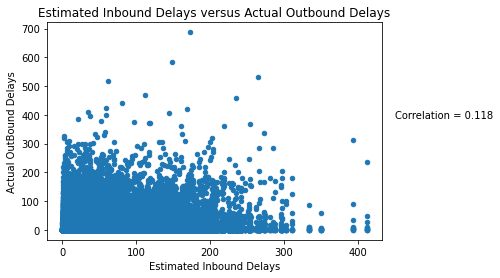

Text(0.5, 1.0, 'Estimated Inbound Delays versus Actual Outbound Delays')

In [0]:
# ax = pd_df.plot.scatter(y="Actual OutBound Delays", x="Estimated Inbound Delays")
# cor = np.round(pd_df.corr().loc["Actual OutBound Delays", 'Estimated Inbound Delays'], 3)
# plt.text(450, 390, f"Correlation = {cor}")
# plt.title("Estimated Inbound Delays versus Actual Outbound Delays")

In [0]:
# pd_df.corr().loc["Actual OutBound Delays", 'Estimated Inbound Delays']

Out[211]: 0.11847563952053429

In [0]:
# plot_df = df.filter("YEAR = 2016").select(*['DEP_DEL15', "estimated_inbound_delays" ]).toPandas()
# cor = np.round(plot_df.corr().loc["DEP_DEL15", "estimated_inbound_delays"], 3)

Out[72]: 0.043

In [0]:
# plot_df

Out[197]:

QUARTER 
 MONTH 
 DAY_OF_MONTH 
 DAY_OF_WEEK 
 OP_CARRIER_AIRLINE_ID 
 OP_CARRIER_FL_NUM 
 ORIGIN_AIRPORT_ID 
 ORIGIN_AIRPORT_SEQ_ID 
 ORIGIN_WAC 
 DEST_AIRPORT_ID 
 DEST_AIRPORT_SEQ_ID 
 DEST_STATE_FIPS 
 DEST_WAC 
 DEP_TIME 
 DEP_DEL15 
 DEP_DELAY_NEW 
 FLIGHTS 
 DISTANCE 
 DISTANCE_GROUP 
 DIV_AIRPORT_LANDINGS 
 DEP_HOUR_OF 
 DEP_HOUR_OF_UTC 
 lat 
 lon 
 neighbor_lat 
 neighbor_lon 
 distance_to_neighbor 
 YEAR 
 MONTH_OBS 
 FLIGHT_HOUR_OBS 
 WND_ANGLE 
 WND_SPEED 
 CIG_DIM 
 VIS_DIST 
 TMP_AIR 
 DEW_POINT 
 SLP_DAY 
 YEAR_OBS 
 id 
 pagerank 
 historical_pagerank 
 hist_pr_id 
 lag_del_by_day 
 estimated_inbound_delays 
 
 
 
 
 0 
 1 
 2 
 16 
 2 
 19790 
 1895 
 14100 
 1410002 
 23 
 10397 
 1039705 
 13 
 34 
 1336.0 
 1.0 
 56.0 
 1.0 
 666.0 
 3 
 0 
 13.0 
 18.0 
 39.873 
 -75.227 
 39.873 
 -75.227 
 0.0 
 2016 
 2.0 
 18.0 
 170.0 
 38.2 
 458.6 
 5775.0 
 59.6 
 62.6 
 10175.6 
 2016.0 
 25769885709 
 0.021281 
 0.009572 
 25769885709 
 4590.0 
 43.937471 
 
 
 1 
 1 
 2 
 16 
 2 
 19790 
 1925 
 10821 
 1082104 
 35 
 10397 
 1039705 
 13 
 34 
 1003.0 
 0.0 
 3.0 
 1.0 
 577.0 
 3 
 0 
 10.0 
 15.0 
 39.173 
 -76.684 
 39.173 
 -76.684 
 0.0 
 2016 
 2.0 
 15.0 
 144.0 
 53.6 
 487.6 
 10138.6 
 86.6 
 85.4 
 10039.0 
 2016.0 
 214748444668 
 0.001722 
 0.009572 
 214748444668 
 4590.0 
 43.937471 
 
 
 2 
 1 
 2 
 16 
 2 
 19790 
 2056 
 13930 
 1393004 
 41 
 10397 
 1039705 
 13 
 34 
 1133.0 
 0.0 
 3.0 
 1.0 
 606.0 
 3 
 0 
 11.0 
 17.0 
 41.995 
 -87.934 
 41.995 
 -87.934 
 0.0 
 2016 
 2.0 
 17.0 
 150.0 
 108.0 
 335.0 
 3219.0 
 122.0 
 100.0 
 10004.0 
 2016.0 
 309237761518 
 0.021281 
 0.009572 
 309237761518 
 4590.0 
 43.937471 
 
 
 3 
 1 
 2 
 16 
 2 
 19790 
 2156 
 11503 
 1150303 
 82 
 10397 
 1039705 
 13 
 34 
 1256.0 
 0.0 
 0.0 
 1.0 
 1312.0 
 6 
 0 
 12.0 
 19.0 
 39.650 
 -106.917 
 39.650 
 -106.917 
 0.0 
 2016 
 2.0 
 19.0 
 320.0 
 51.0 
 2438.0 
 4023.0 
 10.0 
 10.0 
 10146.0 
 2016.0 
 661425057321 
 0.019050 
 0.009572 
 661425057321 
 4590.0 
 43.937471 
 
 
 4 
 1 
 2 
 16 
 2 
 19790 
 14 
 14635 
 1463502 
 33 
 10397 
 1039705 
 13 
 34 
 1421.0 
 1.0 
 25.0 
 1.0 
 515.0 
 3 
 0 
 14.0 
 19.0 
 26.536 
 -81.755 
 26.536 
 -81.755 
 0.0 
 2016 
 2.0 
 19.0 
 350.0 
 0.0 
 22000.0 
 16093.0 
 106.0 
 11.0 
 10199.0 
 2016.0 
 704374649623 
 0.012011 
 0.009572 
 704374649623 
 4590.0 
 43.937471 
 
 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 ... 
 
 
 384247 
 3 
 7 
 5 
 2 
 19790 
 2120 
 13232 
 1323202 
 41 
 10397 
 1039705 
 13 
 34 
 957.0 
 0.0 
 0.0 
 1.0 
 591.0 
 3 
 0 
 9.0 
 14.0 
 41.786 
 -87.752 
 41.786 
 -87.752 
 0.0 
 2016 
 7.0 
 14.0 
 180.0 
 26.0 
 396.0 
 16093.0 
 239.0 
 211.0 
 10058.0 
 2016.0 
 1073741949955 
 0.004100 
 0.040407 
 1073741949955 
 1531.0 
 61.862440 
 
 
 384248 
 3 
 7 
 5 
 2 
 20366 
 5098 
 10208 
 1020803 
 34 
 10397 
 1039705 
 13 
 34 
 NaN 
 NaN 
 NaN 
 1.0 
 143.0 
 1 
 0 
 NaN 
 NaN 
 33.364 
 -81.963 
 33.364 
 -81.963 
 0.0 
 2016 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 NaN 
 1254130464911 
 0.006868 
 0.040407 
 1254130464911 
 1531.0 
 61.862440 
 
 
 384249 
 3 
 7 
 5 
 2 
 20304 
 4774 
 10980 
 1098002 
 54 
 10397 
 1039705 
 13 
 34 
 1154.0 
 0.0 
 0.0 
 1.0 
 106.0 
 1 
 0 
 11.0 
 15.0 
 35.034 
 -85.200 
 35.034 
 -85.200 
 0.0 
 2016 
 7.0 
 15.0 
 100.0 
 15.0 
 244.0 
 16093.0 
 117.0 
 94.0 
 10156.0 
 2016.0 
 1417339273103 
 0.055032 
 0.040407 
 1417339273103 
 1531.0 
 61.862440 
 
 
 384250 
 3 
 7 
 5 
 2 
 20366 
 5275 
 11308 
 1130802 
 51 
 10397 
 1039705 
 13 
 34 
 523.0 
 0.0 
 3.0 
 1.0 
 170.0 
 1 
 0 
 5.0 
 10.0 
 31.317 
 -85.450 
 31.317 
 -85.450 
 0.0 
 2016 
 7.0 
 10.0 
 230.0 
 15.0 
 183.0 
 16093.0 
 106.0 
 94.0 
 10143.0 
 2016.0 
 

Out[76]:

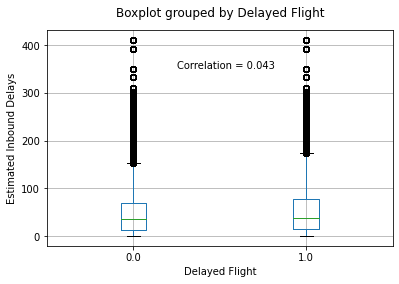

Text(1.25, 350, 'Correlation = 0.043')

In [0]:
# plot_df["Delayed Flight"] = plot_df.loc[:, "DEP_DEL15"]
# ax= plot_df.boxplot(column="estimated_inbound_delays", by="Delayed Flight")
# ax.set_xlabel("Delayed Flight")
# ax.set_ylabel("Estimated Inbound Delays")
# plt.title("")
# cor = np.round(plot_df.corr().loc["DEP_DEL15", "estimated_inbound_delays"], 3)
# plt.text(1.25, 350, f"Correlation = {cor}")

In [0]:
# dbutils.fs().ls(f"{blob_url}/processed-STAGE")
# tables = ["trainDF", "testDF", "minor_df", "major_df", "df_augmentedTrain"]
# for table in tables:
#     t = spark.read.parquet(f"{blob_url}/processed-STAGE/{table}")
#     t.write.mode("overwrite").parquet(f"{blob_url}/processed-prod/{table}")
#     t.unpersist()
#     print(f'finished table: {table}')

finished table: trainDF
finished table: testDF
finished table: minor_df
finished table: major_df
finished table: df_augmentedTrain

In [0]:

# foldedTrainDF= spark.read.parquet(f"{blob_url}/processed-prod/foldedTrainDF")

# display(foldedTrainDF)

DEP_DEL15 DEP_DELAY_NEW scaledFeatures foldCol 1.0 34.0 Map(vectorType -> dense, length -> 923, values -> List(-80.14252618605855, -4.145138347012975E-4, -4.145138347012975E-4, 2412.464300254031, -4.145138347012975E-4, -0.5637181698473925, -0.5855633099710106, -0.5882512893518264, 1.7493874982446354, -0.2963855237218967, 3.312278524673277, -0.2957003110126549, -0.29955121575841037, -0.28216257086370344, -0.30801432567903747, -0.30156325375638265, -0.30556079325398416, -0.3078755490035532, -0.3134684049856055, -0.3100907753595143, -0.29465944639512714, 5.451228121456099, -0.1833502778007676, -0.18408387442860155, -0.18414173423586366, -0.18623453482946592, -0.1830111024221273, -0.18517556196802157, -0.18663418911805027, -0.18436454647782302, -0.18440141005837393, -0.18534126366017864, -0.18667707090162397, -0.18653952327237236, -0.18341284281462664, -0.18506386403889408, -0.18547809392846837, -0.1812012655870164, -0.18236128418681816, -0.18239648822149154, -0.18466375370620916, -0.18440539492697794, -0.1783616648930742, -0.18370989845888575, -0.17801779794612632, -0.1347637698486068, -0.18415220716758005, -0.1835894262725042, -0.18432119867378965, -0.18250256744623444, -0.18567822406410403, -0.18580692186720513, 2.3925044924004784, -0.412014416215003, -0.41523239907008785, -0.4199492736151393, -0.417025911300394, -0.36991936151945376, -0.40432703833014805, -0.24145134967869564, -0.21785086129030906, -0.17336804253343047, -0.2095635771827, -0.23343397192789064, -0.2452348591848092, -0.24695863437934593, -0.2507609644335578, -0.24773111924664076, -0.25407901640083397, -0.24932732623291878, 3.965816448999198, -0.19556887619843305, -0.2543272329553661, -0.2549939817162694, -0.25218721687503387, -0.2525900713970437, -0.15702019022281669, -0.11786398184529293, -0.09760567282149622, -0.0823568519482839, -0.05386262600100243, -0.04531774648741173, -0.1018195668230457, -0.5261523416577744, -0.11523622196226278, -0.4209000376160993, -0.3775150531824486, -0.17478150280817098, -0.31181438744292345, -0.33535186360218067, -0.18801788286476173, -4.145138347012975E-4, -0.3301356168250934, -4.145138347012975E-4, 2412.464300254031, -4.145138347012975E-4, -0.23091951784622006, -0.21929769533337262, -0.14346974682788938, -0.12591755883136005, -4.145138347012975E-4, -0.10368606580818947, -0.020792267021009933, -0.020850082917308152, -0.060183173845281775, -0.011299549347495613, -0.012871035260594325, -0.00946187691150808, -0.017392459599849388, -0.015742562691780024, -0.025627913383249604, -0.004267719628150513, -0.009194749495637183, -0.024280113416080634, -0.021083842323810997, -0.003316128625824061, -0.037548527558601996, -0.010770008976037427, -0.027888240055801438, -0.05449742746615014, -0.01037997142968604, -4.145138347012975E-4, -0.024951025433357556, -0.2641109407566917, -0.023122524817248667, -4.145138347012975E-4, -0.08934763980103404, -0.0228268023710667, -0.015910921447373258, -4.145138347012975E-4, -0.01839183150203897, -0.05947306040102421, -0.01298404766688804, -4.145138347012975E-4, -0.022017539710220104, -4.145138347012975E-4, -0.007484451118911742, -0.008238578396657219, -4.145138347012975E-4, -0.048505449973938, -0.02321161998205671, -0.025547227290851633, -0.011200248571069382, -4.145138347012975E-4, -0.011069050319423117, -4.145138347012975E-4, -0.022595817487935335, -0.0949930197858993, -0.046985283856328997, -0.14386405912991146, -0.013503186775162296, -0.012877710484886003, -0.015742562691780024, -0.010519763001434562, -0.021010304044014785, -0.012689477821267666, -0.011207918311808035, -0.03669920574903788, -0.023912459403191758, -0.056342572970400594, -0.059683634628132816, -0.12819984457573502, -0.02603090702962409, -0.030987119841268344, -0.033666248548758944, -0.01037997142968604, -0.011161820854486732, -0.0057287886829054694, -4.145138347012975E-4, -0.028188986250774664, -0.02048815986339054, -0.047363936414292165, -0.03560076817303577, -0.010746046200956127, -4.145138347012975E-4, -0.010495229140356735, -0.08085584083

In [0]:
# df = spark.read.parquet(f"{blob_url}/feature-engineering/flight_weather_pagerank_historical")
# df = compute_trailing_delays(flight_weather_pagerank_historical=df)
# df = estimate_inbound_delays(df=df)
# print(test.columns)
# assembler = VectorAssembler(inputCols=['DEP_DEL15', 'historical_pagerank', "estimated_inbound_delays"], outputCol="features", handleInvalid="skip")
# d = assembler.transform(df)

['QUARTER', 'MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_CARRIER_AIRLINE_ID', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_WAC', 'DEST_AIRPORT_ID', 'DEST_AIRPORT_SEQ_ID', 'DEST_STATE_FIPS', 'DEST_WAC', 'DEP_TIME', 'DEP_DEL15', 'DEP_DELAY_NEW', 'FLIGHTS', 'DISTANCE', 'DISTANCE_GROUP', 'DIV_AIRPORT_LANDINGS', 'DEP_HOUR_OF', 'DEP_HOUR_OF_UTC', 'lat', 'lon', 'neighbor_lat', 'neighbor_lon', 'distance_to_neighbor', 'YEAR', 'MONTH_OBS', 'FLIGHT_HOUR_OBS', 'WND_ANGLE', 'WND_SPEED', 'CIG_DIM', 'VIS_DIST', 'TMP_AIR', 'DEW_POINT', 'SLP_DAY', 'YEAR_OBS', 'id', 'pagerank', 'historical_pagerank', 'hist_pr_id']

In [0]:
# from pyspark.ml.stat import Correlation
# corr = Correlation.corr(d, 'features')

In [0]:
# print(str(corr.collect()[0][0]))

DenseMatrix([[ 1. , -0.00249555, 0.03710388],
 [-0.00249555, 1. , 0.847168 ],
 [ 0.03710388, 0.847168 , 1. ]])

In [0]:
# sample_df = foldedTrainDF.sample(fraction=0.1, seed=321).cache()

In [0]:
# # first run = 6.5
# pca = PCA(k=100, inputCol="scaledFeatures")
# pca.setOutputCol("pca_features")
# model = pca.fit(sample_df)
# model.transform(sample_df)

In [0]:
# 0.9966326147537363
# 0.997
# 0.9999
# model.explainedVariance.sum()

Out[145]: 0.9997921755348889

In [0]:
# display(model.transform(sample_df))

DEP_DEL15 DEP_DELAY_NEW scaledFeatures foldCol pca_features 1.0 267.0 Map(vectorType -> dense, length -> 923, values -> List(-80.14252618605855, -4.145138347012975E-4, -4.145138347012975E-4, 2412.464300254031, -4.145138347012975E-4, -0.5637181698473925, -0.5855633099710106, -0.5882512893518264, 1.7493874982446354, -0.2963855237218967, 3.312278524673277, -0.2957003110126549, -0.29955121575841037, -0.28216257086370344, -0.30801432567903747, -0.30156325375638265, -0.30556079325398416, -0.3078755490035532, -0.3134684049856055, -0.3100907753595143, -0.29465944639512714, 5.451228121456099, -0.1833502778007676, -0.18408387442860155, -0.18414173423586366, -0.18623453482946592, -0.1830111024221273, -0.18517556196802157, -0.18663418911805027, -0.18436454647782302, -0.18440141005837393, -0.18534126366017864, -0.18667707090162397, -0.18653952327237236, -0.18341284281462664, -0.18506386403889408, -0.18547809392846837, -0.1812012655870164, -0.18236128418681816, -0.18239648822149154, -0.18466375370620916, -0.18440539492697794, -0.1783616648930742, -0.18370989845888575, -0.17801779794612632, -0.1347637698486068, -0.18415220716758005, -0.1835894262725042, -0.18432119867378965, -0.18250256744623444, -0.18567822406410403, -0.18580692186720513, 2.3925044924004784, -0.412014416215003, -0.41523239907008785, -0.4199492736151393, -0.417025911300394, -0.36991936151945376, -0.40432703833014805, -0.24145134967869564, -0.21785086129030906, -0.17336804253343047, -0.2095635771827, -0.23343397192789064, -0.2452348591848092, -0.24695863437934593, 3.987860831677585, -0.24773111924664076, -0.25407901640083397, -0.24932732623291878, -0.252154844037383, -0.19556887619843305, -0.2543272329553661, -0.2549939817162694, -0.25218721687503387, -0.2525900713970437, -0.15702019022281669, -0.11786398184529293, -0.09760567282149622, -0.0823568519482839, -0.05386262600100243, -0.04531774648741173, -0.1018195668230457, -0.5261523416577744, -0.11523622196226278, -0.4209000376160993, -0.3775150531824486, -0.17478150280817098, -0.31181438744292345, -0.33535186360218067, -0.18801788286476173, -4.145138347012975E-4, -0.3301356168250934, -4.145138347012975E-4, 2412.464300254031, -4.145138347012975E-4, -0.23091951784622006, -0.21929769533337262, -0.14346974682788938, -0.12591755883136005, -4.145138347012975E-4, -0.10368606580818947, -0.020792267021009933, -0.020850082917308152, -0.060183173845281775, -0.011299549347495613, -0.012871035260594325, -0.00946187691150808, -0.017392459599849388, -0.015742562691780024, -0.025627913383249604, -0.004267719628150513, -0.009194749495637183, -0.024280113416080634, -0.021083842323810997, -0.003316128625824061, -0.037548527558601996, -0.010770008976037427, -0.027888240055801438, -0.05449742746615014, -0.01037997142968604, -4.145138347012975E-4, -0.024951025433357556, -0.2641109407566917, -0.023122524817248667, -4.145138347012975E-4, -0.08934763980103404, -0.0228268023710667, -0.015910921447373258, -4.145138347012975E-4, -0.01839183150203897, -0.05947306040102421, -0.01298404766688804, -4.145138347012975E-4, -0.022017539710220104, -4.145138347012975E-4, -0.007484451118911742, -0.008238578396657219, -4.145138347012975E-4, -0.048505449973938, -0.02321161998205671, -0.025547227290851633, -0.011200248571069382, -4.145138347012975E-4, -0.011069050319423117, -4.145138347012975E-4, -0.022595817487935335, -0.0949930197858993, -0.046985283856328997, -0.14386405912991146, -0.013503186775162296, -0.012877710484886003, -0.015742562691780024, -0.010519763001434562, -0.021010304044014785, -0.012689477821267666, -0.011207918311808035, -0.03669920574903788, -0.023912459403191758, -0.056342572970400594, -0.059683634628132816, -0.12819984457573502, -0.02603090702962409, -0.030987119841268344, -0.033666248548758944, -0.01037997142968604, -0.011161820854486732, -0.0057287886829054694, -4.145138347012975E-4, -0.028188986250774664, -0.02048815986339054, -0.047363936414292165, -0.03560076817303577, -0.010746046200956127, -4.145138347012975E-4, -0.010495229140356735, -